Inicialmente escrevemos um código para produzir amostras de autômatos:

In [1]:
#Módulos necessários para produzir e salvar as amostras
import numpy
import matplotlib.pyplot as plt

In [2]:
#Essa função retorna um array contendo uma das 256 regras de acordo com o argumento dado
def rule(number):#Função para que produz as regras
    return list( map( int, list(numpy.binary_repr(number,8))))[::-1] #Convert a decimal number to an 8 digit binary number array containing the rules

rules = numpy.array( list(map(rule,numpy.arange(255))) ) #Guarda todas as regras na memória para uso futuro

In [3]:
#Atualiza o autômato para a próxima geração usando uma regra dada e condições de contorno periódicas
def updatePeriodic(input,ruleId):
    output = numpy.zeros(len(input),dtype=int) #O tamanho do output é igual ao do input
    i=0#Quando as condições de contorno são periódicas o último elemento se conecta com o primeiro como um anel
    while i < len(input): #O elemento i=len(input) não possui dois vizinhos, logo, não é válido
        #Tripla atual
        triple = str(input[(i-1)%len(input)])+str(input[i])+str(input[(i+1)%len(input)]) #Produz uma string 000, 010, 001,... correspondendo a uma representação binária de um número inteiro entre 0 e 7
        #Aplica regra para o elemento "i" do output
        output[i] = rules[ruleId][int(triple,2)]
        i=i+1 #Incrementa o contador
    return output

In [4]:
#Evolui o autômato repetidas vezes até o número de passos definidos
def evolve(initialState, ruleId, steps=5,periodicBoundaries=False):
    evolution = numpy.zeros((steps,len(initialState)),dtype=int) #Cria um array steps x len(InitialState) dimensional
    evolution[0] = initialState #O elemento zero é igual ao estado inicial
    step = 1 #Começamos a contar a partir de 1 por conta do que está escrito acima
    if periodicBoundaries:
        while step < steps:
            evolution[step] = updatePeriodic(evolution[step-1],ruleId) #Atualiza o autômato de acordo com a regra "ruleId"
            step = step + 1
    else:
        while step < steps:
            evolution[step] = updateNonPeriodic(evolution[step-1],ruleId) #Atualiza o autômato de acordo com a regra "ruleId"
            step = step + 1
    return evolution

In [5]:
#Produz as amostras e as salva em arquivos csv.
import csv
from IPython.display import clear_output #For a fancier presentation of some kind of progress bar

rule = 30 #Amostras da regra 90
samples = 1024 #Número de amostras
buffer = numpy.empty((10,10))
dim = 10 #Gerações por amostra
for i in numpy.arange(samples):
    clear_output(wait=True)
    print('Working on sample %s / %s' % (i+1,samples) )
    state = numpy.random.randint(2,size=dim)
    buffer = evolve(state,rule,steps = dim,periodicBoundaries=True)
    with open('data/%s/%s.csv' % (rule,i), 'w+', newline='\n') as stream:
        spamwriter = csv.writer(stream, delimiter='\t',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in buffer:
            spamwriter.writerow(row)

Working on sample 1024 / 1024


Com as amostras prontas, prosseguimos para a inicialização e treinamento da rede

In [6]:
#things to import from Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [7]:
#Carrega os dados para a memória
rule = 30#Dados para a regra 30
samples = 1024
raw_data = numpy.empty( (samples,10,10) )

for i in numpy.arange(samples):
    with open('data/%s/%s.csv' % (rule,i), newline ='\n') as file:
        stream = csv.reader(file, delimiter = '\t')
        buffer = list(stream)
        for line in numpy.arange(10): #Já sei que são 10 linhas em cada automato
            raw_data[i][line] = numpy.array(buffer[line])

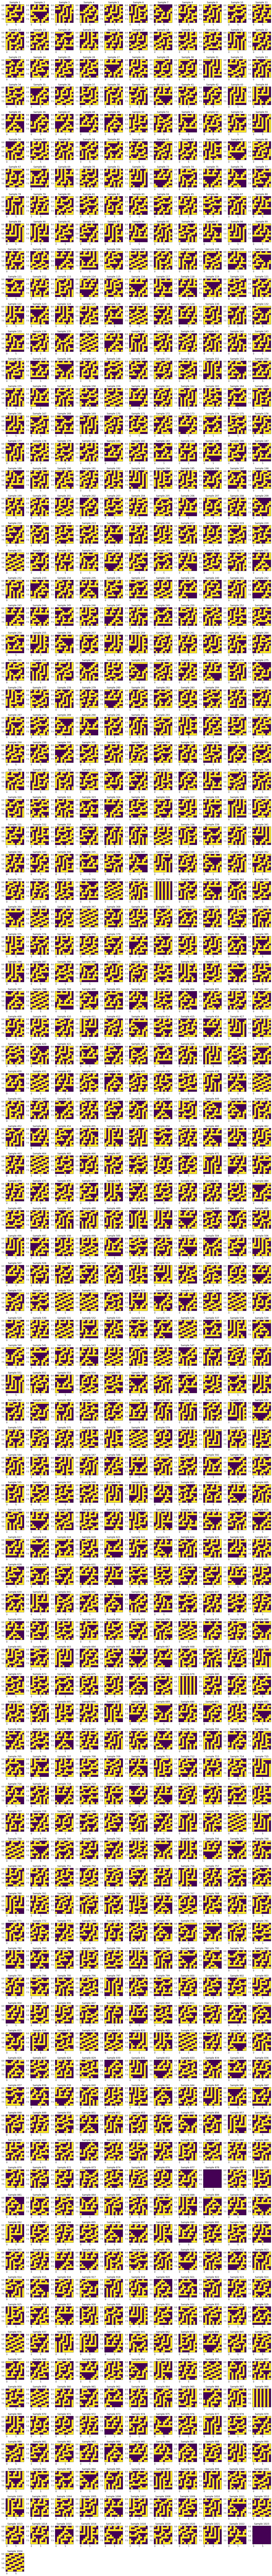

In [8]:
#Produz thumbnails dos samples
thumb_fig = plt.figure(figsize=(20,200))
thumb_ax = []

for i in numpy.arange(samples):
    thumb_ax.append(thumb_fig.add_subplot(100,11,i+1) ) #100 linhas com 10 colunas
    thumb_ax[i].imshow(raw_data[i])
    thumb_ax[i].set_title('Sample %s' % (i+1) )
          
plt.tight_layout()
plt.show()

Usamos uma rede a seguinte estrutura 10 inputs -> 20 hidden -> 10 outputs, onde a primeira usa a ReLu como função de ativação e a última usa a sigmóide. Essa escolha se deu baseada em tentiva e erro. A função ReLu faz a rede convergir mais rapidamente.

In [9]:
#Inicializa uma rede
model = Sequential() #Initilize a linear stack of layers

model.add(Dense(20, activation='relu', use_bias=True, input_dim=10)) #Dense(Neuronios na segunda, activation='sigmoid', use_bias=True, input_dim=Inputs)
model.add(Dense(10, activation='sigmoid') )
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) #Configure the stack for binary classification problem

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 430
Trainable params: 430
Non-trainable params: 0
_________________________________________________________________


In [10]:
rounds = 100
training_input = []
training_target = []

#Prepara os dados de input para o treinamento
for board in raw_data:
    for row in board[0:9]:
        training_input.append( numpy.array( row, dtype = int) )
    for row in board[1:10]:
        training_target.append( numpy.array( row, dtype = int) )
        
#Treina a rede usando a amostra s+1
hist = model.fit( numpy.array( training_input ), numpy.array( training_target ), epochs=rounds, batch_size=32, validation_split = 0.7)

Train on 2764 samples, validate on 6452 samples
Epoch 1/100
2764/2764 [==============================] - 1s 442us/step - loss: 0.6881 - accuracy: 0.5446 - val_loss: 0.6712 - val_accuracy: 0.5798
Epoch 2/100
2764/2764 [==============================] - 1s 265us/step - loss: 0.6636 - accuracy: 0.5990 - val_loss: 0.6500 - val_accuracy: 0.6296
Epoch 3/100
2764/2764 [==============================] - 1s 225us/step - loss: 0.6418 - accuracy: 0.6495 - val_loss: 0.6285 - val_accuracy: 0.6768
Epoch 4/100
2764/2764 [==============================] - 1s 233us/step - loss: 0.6204 - accuracy: 0.6887 - val_loss: 0.6086 - val_accuracy: 0.7033
Epoch 5/100
2764/2764 [==============================] - 1s 300us/step - loss: 0.6007 - accuracy: 0.7162 - val_loss: 0.5901 - val_accuracy: 0.7195
Epoch 6/100
2764/2764 [==============================] - 1s 265us/step - loss: 0.5825 - accuracy: 0.7305 - val_loss: 0.5738 - val_accuracy: 0.7382
Epoch 7/100
2764/2764 [==============================] - 1s 255us/step

2764/2764 [==============================] - 1s 232us/step - loss: 0.0893 - accuracy: 0.9783 - val_loss: 0.0914 - val_accuracy: 0.9774
Epoch 57/100
2764/2764 [==============================] - 1s 212us/step - loss: 0.0853 - accuracy: 0.9792 - val_loss: 0.0873 - val_accuracy: 0.9788
Epoch 58/100
2764/2764 [==============================] - 1s 250us/step - loss: 0.0816 - accuracy: 0.9811 - val_loss: 0.0835 - val_accuracy: 0.9800
Epoch 59/100
2764/2764 [==============================] - 1s 222us/step - loss: 0.0780 - accuracy: 0.9820 - val_loss: 0.0798 - val_accuracy: 0.9815
Epoch 60/100
2764/2764 [==============================] - 1s 205us/step - loss: 0.0745 - accuracy: 0.9831 - val_loss: 0.0761 - val_accuracy: 0.9834
Epoch 61/100
2764/2764 [==============================] - 1s 263us/step - loss: 0.0712 - accuracy: 0.9846 - val_loss: 0.0728 - val_accuracy: 0.9844
Epoch 62/100
2764/2764 [==============================] - 1s 244us/step - loss: 0.0679 - accuracy: 0.9853 - val_loss: 0.0696 

Agora treino a rede usando 90 amostras como validação e 810 como dados de treinamento. Para cada dado treinamos 1200 épocas, essa quantidade é necessária para que a rede produza outputs mais precisos. A rede é treinada para receber uma geração como input e retornar a próxima.

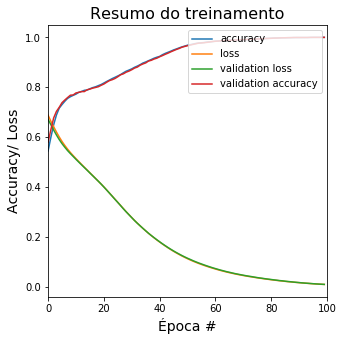

In [13]:
#Plota os resultados do treinamento
fig = plt.figure(figsize=(5,5)) #Inicializa uma figura

axis = {'accuracyLoss': fig.add_subplot(111) } #Inicializa os eixos

#Legendas e decorações dos eixos
axis['accuracyLoss'].set_title('Resumo do treinamento', fontsize = 16)
axis['accuracyLoss'].set_ylabel('Accuracy/ Loss', fontsize = 14)
axis['accuracyLoss'].set_xlabel('Época #', fontsize = 14)
axis['accuracyLoss'].set_xlim(right = rounds)

#Aloca os dados nos eixos
axis['accuracyLoss'].plot( numpy.arange(rounds ), hist.history['accuracy'], label = 'accuracy' )
axis['accuracyLoss'].plot( numpy.arange(rounds ), hist.history['loss'], label = 'loss' )
axis['accuracyLoss'].plot( numpy.arange(rounds ), hist.history['val_loss'], label = 'validation loss' )
axis['accuracyLoss'].plot( numpy.arange(rounds ), hist.history['val_accuracy'], label = 'validation accuracy' )

#Legends
axis['accuracyLoss'].legend(loc = 'upper right')

#Apresenta os gráficos
plt.show()

In [11]:
#Evolui o automato
def evolveNet(initialState, steps=10,periodicBoundaries=False):
    evolution = numpy.zeros((steps,len(initialState)),dtype=float) #Cria um array steps x len(InitialState) dimensional
    evolution[0] = initialState #O elemento zero é igual ao estado inicial
    
    for i in numpy.arange(1,10):
        prediction = model.predict( evolution[i-1].reshape((1,10)) )[0] #previsão da rede
        evolution[i] = prediction #Atualiza o autômato de acordo com a rede

    return evolution

Então podemos testar a rede para estados iniciais variados

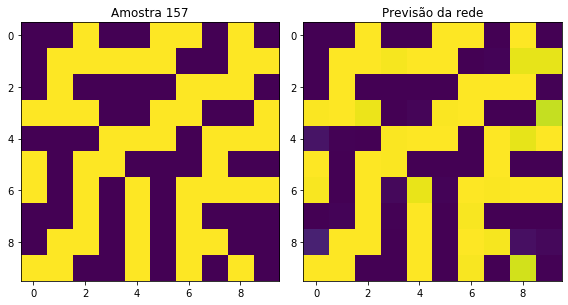

In [12]:
k = 156#Formata a amostra k+1 para testa a rede

training_input = numpy.array( [ numpy.array(raw_data[k][i]) for i in numpy.arange(0,9) ] )
training_target =numpy.array( [ numpy.array(raw_data[k][i]) for i in numpy.arange(1,10) ] )
ev = evolveNet(training_input[0])

#Plota a evolução segundo a rede ao lado da evolução original
result_fig = plt.figure(figsize=(8,8)) #Inicializa uma figura
result_ax = []

result_ax.append(result_fig.add_subplot(1,2,1) ) #100 linhas com 10 colunas
result_ax[0].imshow(raw_data[k])
result_ax[0].set_title('Amostra %s' % (k+1) )

result_ax.append(result_fig.add_subplot(1,2,2) ) #100 linhas com 10 colunas
result_ax[1].imshow(ev )
result_ax[1].set_title('Previsão da rede' )
plt.tight_layout()
plt.show()